In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **Linear-nonlinear-Poisson model – LNPM**

For the last part of the course, we'll learn about the linear-nonlinear-Poisson model. The LNP is a simplified model that has proven useful to describe the output of single neurons. It's overall implementation is shown in the diagram below, which also serves as an outline of the steps you'll follow to implement the model in a simulation.  

<img src="images/LNP_flowchart.png">

Before we begin, it is important to state that it is easier if we work with discrete time units, i.e., with time bins of equal size. Let's take care of that now and define a time bin `dt` of 0.001 (s).

In [15]:
dt = 0.001

# **1) Stimulus** 

If you remember, the contrast values that make up the stimuli we use are determined by drawing numbers randomly from a distribution so a sequence of random numbers suffices as stimulus. 

First, we need to decide how long our stimulus will be. We should have a long enough stimulus so that we can calculate meaningful statistics with it, but not too long that calculations are lengthy and take too much time.

Our stimulus will be generated by choosing numbers randomly from a normal distribution with mean of 0 and standard deviation of 1. 

In [16]:
"""
EXERCISE

Let's say we will record for 1 s. Calculate the number of bins we need and generate 
a sequence of random numbers that we will use as our stimulus. 
You can use the function np.random.randn.

"""

###START CODE HERE###

recording_time = 1000
stimulus_len = int(recording_time / dt)
stimulus = np.random.randn(stimulus_len)

###END CODE HERE###

We can plot the beginning of our stimulus, to see what it looks like.

Also to see that we actually have normally distributed values, we can take a look at the histogram.

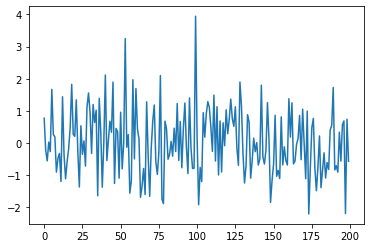

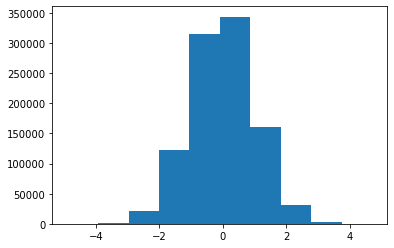

In [17]:
###START CODE HERE###

plt.plot(stimulus[:200])
plt.show()
plt.hist(stimulus)
plt.show()

###END CODE HERE###


# **2) Linear Filter**

The linear filter determines what your neuron is "interested" in **in the temporal domain**. In very general terms, filtering means letting through what is wanted while letting out what is not. The more similar a signal is to a neuron's filter, the higher the chance it will go through and be picked up by it; the more the signal differs from the filter, the likelier it will be ignored.  How long is a filter? It depends on the memory of the neuron, i.e., how farther in the past can a signal bear influence on spiking in the present. For retinal cells, a filter extending to 600 ms before the spike is typically long enough to capture everything, with most of the interesting things happening between 0 and 200 ms before the spike. To give you an idea, it might look something like this:

<img src="images/linear_filter.png">

We can use a Gaussian-like function:

$$
f(t) = a e^{-(t-b)^{2}/2c^{2}}
$$
where $a$ is the height, $b$ is the x coordinate of the center of the bump and $c$ is the width. A curve like that in the image above can be obtained by a difference of two Gaussian functions.



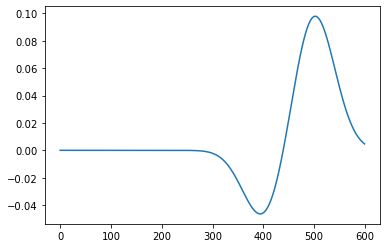

In [27]:
"""
EXERCISE

Use the equation above to define a function that returns
a Gaussian curve. Arguments should be the variables a, b, c and t.

Define how long you want the filter to be and a vector from zero to the total duration 
of the filter in dt steps.

Obtain a linear filter from a difference of Gaussians and plot.



"""
###START CODE HERE###

def gaussian(a, b, c, t):

    f = a*np.exp((-(t-b)**2) / (2*(c**2)))

    return f


filter_t_max = 0.600

time_vector = np.arange(0, filter_t_max, dt)

linear_filter = gaussian(0.1, .500, 0.040, time_vector) - gaussian(0.05, .400, 0.040, time_vector)

plt.plot(linear_filter);

###END CODE HERE###


# **3) Convolution and filtering**

To implement the filtering in the simulation we should somehow "pass" the entire signal through the filter. The mathematical operation we use for this is called *convolution*. What it does is, it "slides" the filter along the signal making a point-to-point multiplication at each step: similarities will produce larger positive values. 

<img src="images/convolution.gif">

We can use the numpy function `np.convolve`.

In [6]:
a = [1, 2, 3]
b = [0.5, 1, 0]

print(np.convolve(a, b))

[0.5 2.  3.5 3.  0. ]


The numpy function flips the second argument before applying the operation, because this is the convention for other applications of convolution; but this is something we would like to avoid. So we when supplying the second argument, we flip it.

In the LNP model, the result of convolution of the stimulus and the filter is called the *generator signal*. The generator signal should have the same length as the stimulus.

In [7]:
"""
EXERCISE

Define a function that takes the stimulus and linear_filer as arguments
and returns the generator signal.

Use the function with your previously defined stimulus and linear_filter
to obtain the generator signal and compare its size to the stimulus'.

"""
###START CODE HERE###

def convolve_stimulus(stimulus, linear_filter):
    
    # Flip the linear filter
    linear_filter = linear_filter[::-1]
    
    # Perform the actual convolution, which results in a longer array than the stimulus
    convolution_full = np.convolve(stimulus, linear_filter)
    
    # Finally we trim the end to obtain the generator signal
    filter_len = len(linear_filter)

    generator = convolution_full[:-filter_len+1]
    
    return generator

generator = convolve_stimulus(stimulus, linear_filter)

print(generator.shape, stimulus.shape)

###END CODE HERE###

(1000000,) (1000000,)


Now for every value in the stimulus array, we have a corresponding generator value.

# **4) Nonlinearity** 

In order to get the instantaneous firing rate of the neuron at each point of the generator signal, we need to apply a nonlinear transformation. Don't let the name fool you, you can also have a nonlinearity that looks like a line. Keep in mind that neurons cannot have a negative firing rate, so the output of the nonlinear transformation should always be positive.

A basic nonlinear function would be a rectifying linear function; if the generator is less than zero, there are no spikes; otherwise, the firing rate is the generator signal scaled by some number.

In [8]:
"""
EXERCISE

To calculate the instantaneous firing rate at each step, take the generator signal, 
multiply everything by 0.2 and set all the negative values to zero.
You can make use of logical arrays or loops.

"""

###START CODE HERE###

firing_rate = generator * 0.2
firing_rate[firing_rate < 0] = 0

###END CODE HERE###

# **5) Poisson process and ¡¡spikes!!**

We can assign spikes to each time bin by drawing a random number from a Poisson distribution, based on the instantaneous firing rate at that bin. The higher the firing rate, the more spikes.

Poisson process assumes the events are independent, which is not entirely true due to refractory period, but it is still close enough for our purposes.

Check the numpy Poisson function you can use for this purpose.

In [9]:
"""
EXERCISE

Generate spikes using the numpy function, plot an initial portion of the result
and print the total number of spikes.

"""
###START CODE HERE###

spikes = np.random.poisson(firing_rate)

plt.plot(spikes[:200], 'o')
plt.show()
print('Total number of spikes is ', spikes.sum())

###END CODE HERE###

**Putting it together**

Now, go back to the beginning and start by yourself. Create a new stimulus array. Create a new filter: you may play with all the parameters of the Gaussian function and with the length of the filter; you could also try to get a monophasic filter. Try out a nonlinearity of your choice. Once done, move on to section 6.

# **6) Recovering the filter**

Now that we have spikes, we can try to recover the filter we put in. If everthing goes well, you the STA you calculate should look very similar to the filter we put in.

For this we will calculate the spike triggered average like you did in the morning, but now using binned spikes.


In [11]:
"""
EXERCISE

First initialize an array with zeros, with the same shape as the linear filter.
Then, using a for loop, calculate the sum of the stimulus segments preceding each spike. 
If there are multiple spikes in each bin, you should count that stimulus segment multiple times.
Then divide this sum by the total number of spikes to get the average.

"""

###START CODE HERE###

sta = np.zeros(linear_filter.shape)
filter_len = len(linear_filter)

for i, spike in enumerate(spikes):
    if i > filter_len:
        sta += spike * stimulus[i-filter_len+1:i+1]
sta = sta/spikes.sum()

###END CODE HERE###

Now you can plot the STA and the linear_filter and compare them.

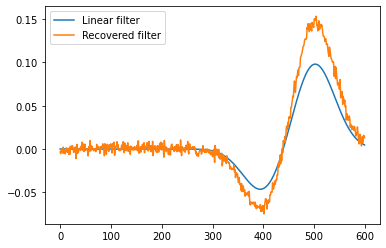

In [12]:
###START CODE HERE###
plt.plot(linear_filter, label='Linear filter')
plt.plot(sta, label='Recovered filter')
plt.legend()

plt.show()
###END CODE HERE###

# **7) Want to go beyond?**


What can you do now? There are many options:

- We have used eventplot to visualize spike times before, you can think about trying to convert binned spikes into spike times, if you'd like to use that function.

- On day 1, we learned about basic spike train statistics. You can use those analyses to explore your simulated spikes, which you should first "translate" to spike times.

- You can see what effect different linear filters and nonlinear functions have on the spike train statistics.

- How does the STA look like when you change the nonlinear function to be symmetrical with respect to the y axis?

- Not satiated yet? You could try to recover the nonlinearity from the generator signal.
